In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import seaborn as sns
import os 
import re

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.style.use('bmh')

from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from datetime import datetime

#plt.style.use('fivethirtyeight')
%pprint # turn pretty printing off 

Pretty printing has been turned OFF


# Missing data imputation

In [ ]:
# Get all 时事 data
files = [file for file in os.listdir('../data/china_press/') if ('complete' in file) & ('时事' in file)]
files = (pd.read_csv('../data/china_press/' + f) for f in files) # use generator comprehension for efficiency
df = pd.concat(files, ignore_index=True)
print(df.shape)
df.head()

In [ ]:
# Check missing data across columns 
df.isna().sum(axis=0)

In [ ]:
miss_ind = df.loc[df['article'].isna(), :].index
miss_ind

In [ ]:
# Create lists to store information of articles
dates = []
views = []
texts = []

# Open a browser
driver = webdriver.Chrome()

for link in df.loc[miss_ind, 'link']:
    try:
        driver.get(link)
    except TimeoutException:
        # Stop pending requests when taking longer than 20s to load 
        driver.execute_script("window.stop();")
        print('Maximum time exceeded:', link)
    
    try:
        date = driver.find_element_by_xpath("//time[@class='entry-date published']").text
        view = driver.find_element_by_xpath("//span[contains(@class, 'count_view')]").text
        text = ''.join([paragraph.text for paragraph in driver.find_elements_by_xpath("//div[@class='entry-content clearfix']/p")])

        dates.append(date)
        views.append(view)
        texts.append(text)
    except:
        dates.append(None)
        views.append(None)
        texts.append(None)
        
# Close the browser
driver.quit()

df.loc[miss_ind, 'date'] = dates
df.loc[miss_ind, 'view'] = views
df.loc[miss_ind, 'article'] = texts

In [ ]:
df.to_csv('data/data_时事_complete.csv', index=False, encoding='utf-8-sig')

# Variables cleaning

In [2]:
# Import data 
df = pd.read_csv('data/data_时事_complete.csv')
print(df.shape)
df.head()

(53893, 5)


,title,link,date,view,article
0,◤头条抢鲜看◢ 2021年7月8日,https://www.chinapress.com.my/20210707/%e2%97%...,2021年7月07日,11512点阅,巫统撤回支持 敦促首相下台\nhttps://www.chinapress.com.my/?...
1,◤新冠又一年◢ 女子引爆霹雪跨州感染群 验61人 34人确诊,https://www.chinapress.com.my/20210707/%e2%97%...,2021年7月07日,28478点阅,（吉隆坡7日讯）国内今日新增1个横跨霹雳和雪兰莪的社区新冠肺炎感染群，首发患者是1名拥有跨州...
2,纳兹里：委任依斯迈及希山 能稳定国内政局,https://www.chinapress.com.my/20210707/%e7%ba%...,2021年7月07日,16502点阅,（吉隆坡7日讯）巫统硝山国会议员拿督斯里纳兹里指出，委任拿督斯里依斯迈沙比里担任副首相和让拿...
3,敦马致函议长 要求尽早开国会,https://www.chinapress.com.my/20210707/%e6%95%...,2021年7月07日,9832点阅,（吉隆坡7日讯）前首相敦马哈迪说，他已致函向国会下议院议长拿督阿兹哈阿兹占提呈动议，要求尽早...
4,◤雪州EMCO◢ MITI：雪EMCO区 更多领域可开了,https://www.chinapress.com.my/20210707/%e2%97%...,2021年7月07日,183974点阅,（吉隆坡7日讯）国际贸易与工业部宣布，雪州强化行动管制令地区的电气与电子（E&E）行业及其供...


In [3]:
# Drop empty articles eg. videos and pictures 
# df.loc[df.article.isna(), :]
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(53562, 5)

In [4]:
# Convert date from str to datetime 
df.date = df.date.str.rstrip('日').str.split('年|月').str.join('-')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.date.describe(datetime_is_numeric=True)
#df.date.value_counts().sort_index().plot(kind='bar', figsize=(15,8), rot=30)

count                            53562
mean     2019-08-07 00:41:25.762294272
min                2017-01-01 00:00:00
25%                2018-07-26 00:00:00
50%                2019-10-10 00:00:00
75%                2020-09-16 00:00:00
max                2021-07-07 00:00:00
Name: date, dtype: object

Text(0.5, 1.0, 'Number of articles per year in China Press')

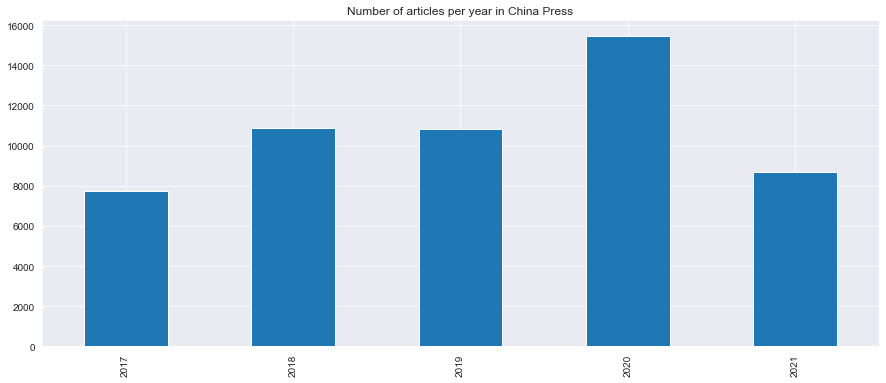

In [5]:
# Number of articles per year
fig, ax = plt.subplots()
bar = df.date.dt.year.value_counts().sort_index().plot(kind='bar', figsize=(15, 6))
plt.title('Number of articles per year in China Press')

In [6]:
df.date.dt.year.value_counts().sort_index()

2017     7732
2018    10857
2019    10831
2020    15468
2021     8674
Name: date, dtype: int64

count     53562.000000
mean      12571.304264
std       25043.384138
min           1.000000
25%        2509.000000
50%        6488.000000
75%       13476.500000
max      989197.000000
Name: view, dtype: float64


<AxesSubplot:ylabel='Frequency'>

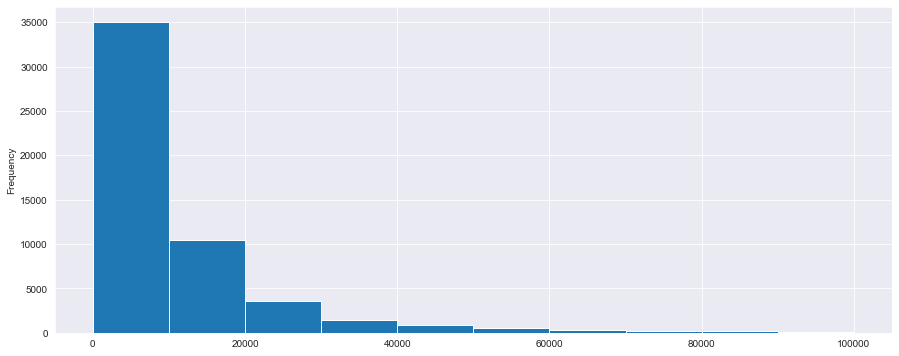

In [21]:
# Clean 'view' and visualize its distribution
df.view = df.view.str.rstrip('点阅').astype(int)
print(df.view.describe())
df.view.plot(kind='hist', figsize=(15, 6), range=(0, 100000))

count    53562.000000
mean       484.953512
std        324.196136
min          8.000000
25%        296.000000
50%        422.000000
75%        579.000000
max      10810.000000
Name: len, dtype: float64


<AxesSubplot:ylabel='Frequency'>

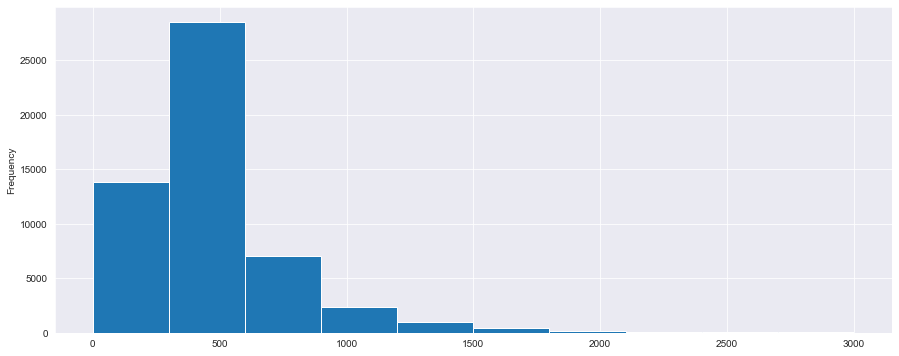

In [7]:
# Get articles' length and visualize its distribution
df['len'] = df.article.apply(lambda text: len(text))
print(df.len.describe())
df.len.plot(kind='hist', figsize=(15, 6), range=(0, 3000))

# Text processing


1. Remove unnecessary texts eg. `\n` and urls
2. Convert articles in traditional Chinese to simplified Chinese
3. Perform tokenizations followed by removal of punctuation and numbers

* English characters are not removed because they are generally acronyms of organizations

## Remove unnecessary texts

In [10]:
# Preprocessing before tokenization 
def clean_text(text):
    '''Remove unnessary texts and return the location and date in an article'''
    # Remove \n
    text = text.replace('\n', ' ')
    
    # Remove url if present
    text = re.sub('https:\/\/[\x00-\x7F]+', '', text) # only ASCII characters in url 
    
    # Get location and date at the beginning if present
    if re.search('（[^\s]+）', text):
        loc_date = re.search('（[^\s）]+）', text)[0]
        text = text.replace(loc_date, '')
        return [text, loc_date]
    else:
        return [text, None]

# Example
text = df.article[0]
print(text)
clean_text(text)

巫统撤回支持 敦促首相下台
https://www.chinapress.com.my/?p=2582191慕尤丁宣布依斯迈任副揆 希山升高级部长
https://www.chinapress.com.my/?p=2581333◤新冠又一年◢ 病患满到泄 医院难负荷 病床 排到门外
https://www.chinapress.com.my/?p=2581775◤新冠又一年◢ 疑2变种病毒夹攻 吉苏丹阿都哈林医院30人中招
https://www.chinapress.com.my/?p=2581609◤新冠又一年◢ 每日病例起起起 雪 隆 森 纳闽 医院 随时瘫
https://www.chinapress.com.my/?p=2581985


['巫统撤回支持 敦促首相下台 慕尤丁宣布依斯迈任副揆 希山升高级部长 ◤新冠又一年◢ 病患满到泄 医院难负荷 病床 排到门外 ◤新冠又一年◢ 疑2变种病毒夹攻 吉苏丹阿都哈林医院30人中招 ◤新冠又一年◢ 每日病例起起起 雪 隆 森 纳闽 医院 随时瘫 ', None]

In [11]:
# Apply clean_text to 'article' column
df['loc_date'] = [clean_text(article)[1] for article in df.article]
df['article'] = [clean_text(article)[0] for article in df.article]
df.head()

,title,link,date,view,article,len,loc_date
0,◤头条抢鲜看◢ 2021年7月8日,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,11512,巫统撤回支持 敦促首相下台 慕尤丁宣布依斯迈任副揆 希山升高级部长 ◤新冠又一年◢ 病患满到...,326,None
1,◤新冠又一年◢ 女子引爆霹雪跨州感染群 验61人 34人确诊,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,28478,国内今日新增1个横跨霹雳和雪兰莪的社区新冠肺炎感染群，首发患者是1名拥有跨州记录的大马公民！...,152,（吉隆坡7日讯）
2,纳兹里：委任依斯迈及希山 能稳定国内政局,https://www.chinapress.com.my/20210707/%e7%ba%...,2021-07-07,16502,巫统硝山国会议员拿督斯里纳兹里指出，委任拿督斯里依斯迈沙比里担任副首相和让拿督斯里希山慕丁担...,233,（吉隆坡7日讯）
3,敦马致函议长 要求尽早开国会,https://www.chinapress.com.my/20210707/%e6%95%...,2021-07-07,9832,前首相敦马哈迪说，他已致函向国会下议院议长拿督阿兹哈阿兹占提呈动议，要求尽早召开国会，而不是...,299,（吉隆坡7日讯）
4,◤雪州EMCO◢ MITI：雪EMCO区 更多领域可开了,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,183974,国际贸易与工业部宣布，雪州强化行动管制令地区的电气与电子（E&E）行业及其供应链、航空领域（...,279,（吉隆坡7日讯）


## Traditional Chinese Conversion

1. Distinguish articles in traditional and simplified Chinese for better tokenization
    - attempted `hanzidentifier` which resulted in inaccurate classification
    - manually examined the cut point: 2018/09/16, but some following articles are still in Traditional Chinese eg. article `32404`, `32406`

| Year | Chinese |
| --- | --- |
| 2017 | Traditional |
| 2018 | Mixed |
| 2019 | Simplified |
| 2020 | Simplified |
| 2021 | Simplified |

2. Convert all traditional Chinese articles to simplified Chinese
    - [langconv's GitHub repo](https://github.com/skydark/nstools)
    - [Python conversion](https://xken831.pixnet.net/blog/post/463639202-%5Bpython%5D-python-%E7%B0%A1%E8%BD%89%E7%B9%81%E3%80%81%E7%B9%81%E8%BD%89%E7%B0%A1)


In [12]:
# import hanzidentifier
from langconv import Converter

In [ ]:
# print(hanzidentifier.is_simplified(df.article[32643]))
# print(hanzidentifier.is_traditional(df.article[32643]))

In [ ]:
# cutting point exception 
# df.loc[32400:, :].head(10) 

In [13]:
# Convert articles in 2017 and 2018 to simplified Chinese
years = [2017, 2018]
for year in years:
    df.loc[df.date.dt.year == year, 'article'] = df.loc[df.date.dt.year == year, 'article'].apply(Converter('zh-hans').convert)

## Tokenization

1. Created a dictionary for better tokenization.
    - Scraped the names of Malaysian politicians in each cabinet from 2017-2021
    - Included Malaysia's political parties that are not recognized by `jieba`
    - Included words that refer to an ethnic group eg. `马来民族`
    - Included words that are common in Malaysians' Chinese eg. `令吉`, `巴仙`
    - Included proper nouns for places and companies

References
1. Jieba: https://github.com/fxsjy/jieba

In [ ]:
# import pkuseg
# seg = pkuseg.pkuseg()  
# seg.cut(df.article[2])

In [ ]:
# import jieba
# list(jieba.cut(df.article[2]))

In [14]:
import jieba
jieba.load_userdict("data/jieba_userdict.txt")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 0.543 seconds.
Prefix dict has been built successfully.


In [24]:
print(df.article[0])
list(jieba.cut(df.article[0]))

巫统撤回支持 敦促首相下台 慕尤丁宣布依斯迈任副揆 希山升高级部长 ◤新冠又一年◢ 病患满到泄 医院难负荷 病床 排到门外 ◤新冠又一年◢ 疑2变种病毒夹攻 吉苏丹阿都哈林医院30人中招 ◤新冠又一年◢ 每日病例起起起 雪 隆 森 纳闽 医院 随时瘫 


['巫统', '撤回', '支持', ' ', '敦促', '首相', '下台', ' ', '慕尤丁', '宣布', '依斯迈', '任', '副揆', ' ', '希山', '升', '高级', '部长', ' ', '◤', '新冠', '又', '一年', '◢', ' ', '病患', '满到', '泄', ' ', '医院', '难', '负荷', ' ', '病床', ' ', '排', '到', '门外', ' ', '◤', '新冠', '又', '一年', '◢', ' ', '疑', '2', '变种', '病毒', '夹攻', ' ', '吉', '苏丹', '阿都', '哈林', '医院', '30', '人', '中招', ' ', '◤', '新冠', '又', '一年', '◢', ' ', '每日', '病例', '起起', '起', ' ', '雪', ' ', '隆', ' ', '森', ' ', '纳闽', ' ', '医院', ' ', '随时', '瘫', ' ']

In [18]:
# Perform tokenization
df['tokens'] = df.article.apply(jieba.cut).apply(list)
df.head()

,title,link,date,view,article,len,loc_date,tokens
0,◤头条抢鲜看◢ 2021年7月8日,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,11512,巫统撤回支持 敦促首相下台 慕尤丁宣布依斯迈任副揆 希山升高级部长 ◤新冠又一年◢ 病患满到...,326,None,"[巫统, 撤回, 支持, , 敦促, 首相, 下台, , 慕尤丁, 宣布, 依斯迈, 任..."
1,◤新冠又一年◢ 女子引爆霹雪跨州感染群 验61人 34人确诊,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,28478,国内今日新增1个横跨霹雳和雪兰莪的社区新冠肺炎感染群，首发患者是1名拥有跨州记录的大马公民！...,152,（吉隆坡7日讯）,"[国内, 今日, 新增, 1, 个, 横跨, 霹雳, 和, 雪兰莪, 的, 社区, 新冠, ..."
2,纳兹里：委任依斯迈及希山 能稳定国内政局,https://www.chinapress.com.my/20210707/%e7%ba%...,2021-07-07,16502,巫统硝山国会议员拿督斯里纳兹里指出，委任拿督斯里依斯迈沙比里担任副首相和让拿督斯里希山慕丁担...,233,（吉隆坡7日讯）,"[巫统, 硝山, 国会议员, 拿督斯里, 纳兹里, 指出, ，, 委任, 拿督斯里, 依斯迈..."
3,敦马致函议长 要求尽早开国会,https://www.chinapress.com.my/20210707/%e6%95%...,2021-07-07,9832,前首相敦马哈迪说，他已致函向国会下议院议长拿督阿兹哈阿兹占提呈动议，要求尽早召开国会，而不是...,299,（吉隆坡7日讯）,"[前首相, 敦马哈迪, 说, ，, 他, 已, 致函, 向, 国会, 下议院, 议长, 拿督..."
4,◤雪州EMCO◢ MITI：雪EMCO区 更多领域可开了,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,183974,国际贸易与工业部宣布，雪州强化行动管制令地区的电气与电子（E&E）行业及其供应链、航空领域（...,279,（吉隆坡7日讯）,"[国际贸易, 与, 工业部, 宣布, ，, 雪州, 强化, 行动, 管制, 令, 地区, 的..."


In [33]:
# Remove punctuation from tokenized outputs 
punc = " ！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、，〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.◤◢"
remove_punc = lambda tokens: [token for token in tokens if token not in punc]
df.tokens = df.tokens.apply(remove_punc)

# Remove number from tokenized outputs 
remove_num = lambda tokens: [token for token in tokens if re.match('[0-9]+', token) == None]
df.tokens = df.tokens.apply(remove_num)

In [35]:
# Count number of tokens
df['no_tokens'] = df.tokens.apply(lambda text: len(text))
df.head()

,title,link,date,view,article,len,loc_date,tokens,no_tokens
0,◤头条抢鲜看◢ 2021年7月8日,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,11512,巫统撤回支持 敦促首相下台 慕尤丁宣布依斯迈任副揆 希山升高级部长 ◤新冠又一年◢ 病患满到...,326,None,"[巫统, 撤回, 支持, 敦促, 首相, 下台, 慕尤丁, 宣布, 依斯迈, 任, 副揆, ...",56
1,◤新冠又一年◢ 女子引爆霹雪跨州感染群 验61人 34人确诊,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,28478,国内今日新增1个横跨霹雳和雪兰莪的社区新冠肺炎感染群，首发患者是1名拥有跨州记录的大马公民！...,152,（吉隆坡7日讯）,"[国内, 今日, 新增, 个, 横跨, 霹雳, 和, 雪兰莪, 的, 社区, 新冠, 肺炎,...",73
2,纳兹里：委任依斯迈及希山 能稳定国内政局,https://www.chinapress.com.my/20210707/%e7%ba%...,2021-07-07,16502,巫统硝山国会议员拿督斯里纳兹里指出，委任拿督斯里依斯迈沙比里担任副首相和让拿督斯里希山慕丁担...,233,（吉隆坡7日讯）,"[巫统, 硝山, 国会议员, 拿督斯里, 纳兹里, 指出, 委任, 拿督斯里, 依斯迈沙比里...",97
3,敦马致函议长 要求尽早开国会,https://www.chinapress.com.my/20210707/%e6%95%...,2021-07-07,9832,前首相敦马哈迪说，他已致函向国会下议院议长拿督阿兹哈阿兹占提呈动议，要求尽早召开国会，而不是...,299,（吉隆坡7日讯）,"[前首相, 敦马哈迪, 说, 他, 已, 致函, 向, 国会, 下议院, 议长, 拿督, 阿...",136
4,◤雪州EMCO◢ MITI：雪EMCO区 更多领域可开了,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,183974,国际贸易与工业部宣布，雪州强化行动管制令地区的电气与电子（E&E）行业及其供应链、航空领域（...,279,（吉隆坡7日讯）,"[国际贸易, 与, 工业部, 宣布, 雪州, 强化, 行动, 管制, 令, 地区, 的, 电...",127


In [36]:
pickle.dump(df, open("data/data_时事_clean", "wb"))

# EDA

In [3]:
df = pickle.load(open("data/data_时事_clean", "rb"))
print(df.shape)
df.head()

(53562, 9)


,title,link,date,view,article,len,loc_date,tokens,no_tokens
0,◤头条抢鲜看◢ 2021年7月8日,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,11512,巫统撤回支持 敦促首相下台 慕尤丁宣布依斯迈任副揆 希山升高级部长 ◤新冠又一年◢ 病患满到...,326,None,"[巫统, 撤回, 支持, 敦促, 首相, 下台, 慕尤丁, 宣布, 依斯迈, 任, 副揆, ...",56
1,◤新冠又一年◢ 女子引爆霹雪跨州感染群 验61人 34人确诊,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,28478,国内今日新增1个横跨霹雳和雪兰莪的社区新冠肺炎感染群，首发患者是1名拥有跨州记录的大马公民！...,152,（吉隆坡7日讯）,"[国内, 今日, 新增, 个, 横跨, 霹雳, 和, 雪兰莪, 的, 社区, 新冠, 肺炎,...",73
2,纳兹里：委任依斯迈及希山 能稳定国内政局,https://www.chinapress.com.my/20210707/%e7%ba%...,2021-07-07,16502,巫统硝山国会议员拿督斯里纳兹里指出，委任拿督斯里依斯迈沙比里担任副首相和让拿督斯里希山慕丁担...,233,（吉隆坡7日讯）,"[巫统, 硝山, 国会议员, 拿督斯里, 纳兹里, 指出, 委任, 拿督斯里, 依斯迈沙比里...",97
3,敦马致函议长 要求尽早开国会,https://www.chinapress.com.my/20210707/%e6%95%...,2021-07-07,9832,前首相敦马哈迪说，他已致函向国会下议院议长拿督阿兹哈阿兹占提呈动议，要求尽早召开国会，而不是...,299,（吉隆坡7日讯）,"[前首相, 敦马哈迪, 说, 他, 已, 致函, 向, 国会, 下议院, 议长, 拿督, 阿...",136
4,◤雪州EMCO◢ MITI：雪EMCO区 更多领域可开了,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,183974,国际贸易与工业部宣布，雪州强化行动管制令地区的电气与电子（E&E）行业及其供应链、航空领域（...,279,（吉隆坡7日讯）,"[国际贸易, 与, 工业部, 宣布, 雪州, 强化, 行动, 管制, 令, 地区, 的, 电...",127


In [4]:
# Get no. of articles each year
df.date.dt.year.value_counts().sort_index()

2017     7732
2018    10857
2019    10831
2020    15468
2021     8674
Name: date, dtype: int64

In [5]:
# Get no. of tokens each year
print(df.no_tokens.sum())
df.groupby(df.date.dt.year)['no_tokens'].sum()

11983560


date
2017    2195294
2018    2715899
2019    2633147
2020    2947058
2021    1492162
Name: no_tokens, dtype: int64

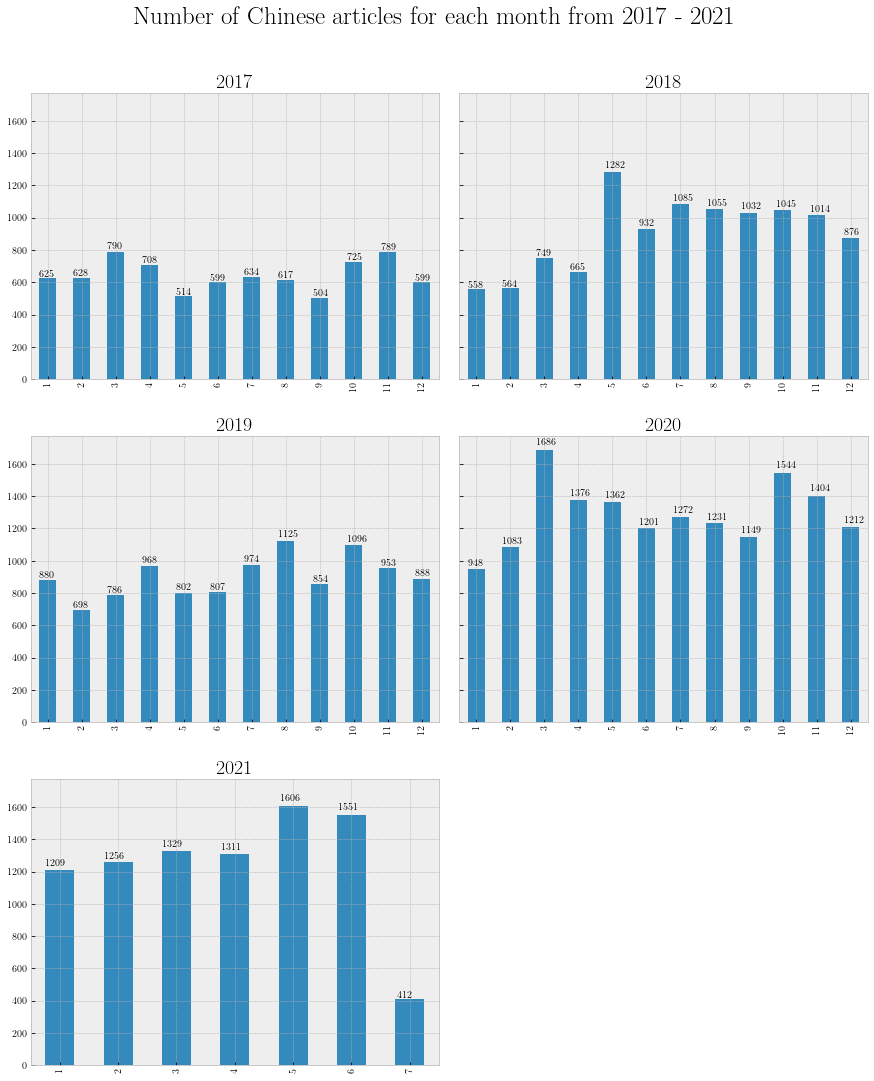

In [6]:
# Plot no. of articles per month
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
title = 'Number of Chinese articles for each month from 2017 - 2021'
years = np.sort(df.date.dt.year.unique())

for idx in range(len(axes)):
    ax = axes[idx]
    if idx <= len(years)-1:
        year = years[idx]
        data = df.loc[df.date.dt.year == year, 'date']
        data.dt.month.value_counts().sort_index().plot(kind='bar', ax=ax)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
        ax.set_title(year, fontdict={'fontsize': 20})
    else:
        ax.set_axis_off()

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.90, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/chi_no_articles_monthly.eps', format='eps')

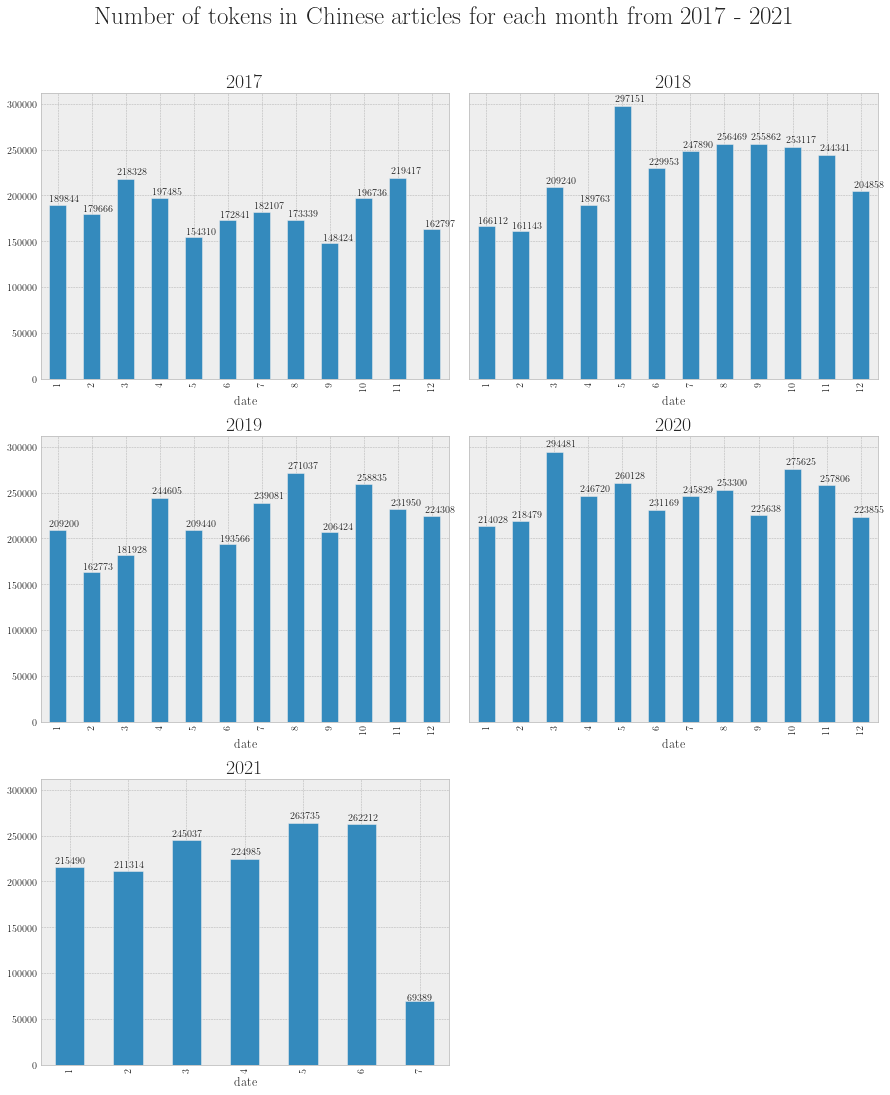

In [22]:
# Plot no. of tokens per month
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
title = 'Number of tokens in Chinese articles for each month from 2017 - 2021'
years = np.sort(df.date.dt.year.unique())

for idx in range(len(axes)):
    ax = axes[idx]
    if idx <= len(years)-1:
        year = years[idx]
        data = df.loc[df.date.dt.year == year, :]
        data.groupby(data.date.dt.month)['no_tokens'].sum().sort_index().plot(kind='bar', ax=ax)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
        ax.set_title(year, fontdict={'fontsize': 20})
    else:
        ax.set_axis_off()

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.90, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/no_tokens_monthly.eps', format='eps')

count    53562.000000
mean       223.732497
std        151.048293
min          0.000000
25%        133.000000
50%        194.000000
75%        268.000000
max       4731.000000
Name: no_tokens, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


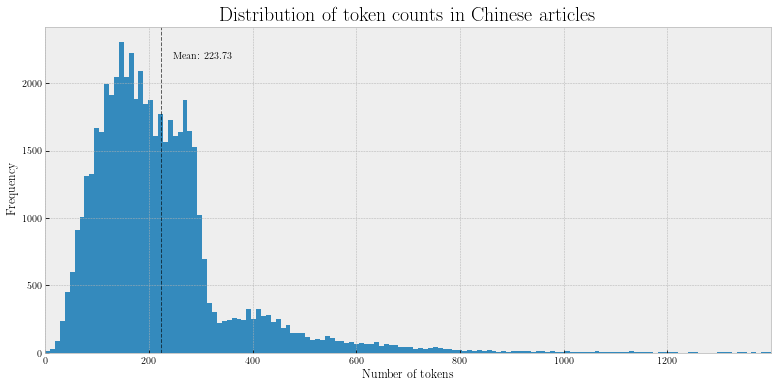

In [7]:
# Plot distribution of tokens number
print(df.no_tokens.describe())
fig, ax = plt.subplots(figsize=(13, 6))
ax = df.no_tokens.plot(kind='hist', bins=500)

plt.axvline(df.no_tokens.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df.no_tokens.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.no_tokens.mean()))

ax.set_xlabel('Number of tokens')
ax.set_title('Distribution of token counts in Chinese articles', fontdict={'fontsize': 20})
ax.set_xlim(0, df.no_tokens.quantile(0.999))
plt.savefig('figs/chi_dist_tokens_count.eps', format='eps')

count    53562.000000
mean       223.732497
std        151.048293
min          0.000000
25%        133.000000
50%        194.000000
75%        268.000000
max       4731.000000
Name: no_tokens, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


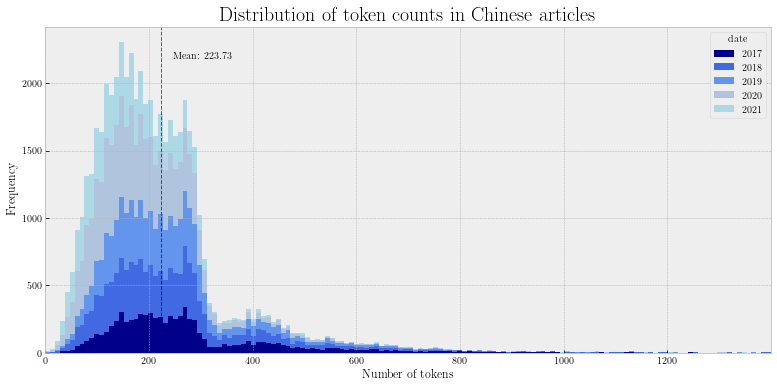

In [8]:
# Plot distribution of tokens number by years 
print(df.no_tokens.describe())

df_hist = df.loc[:, ['no_tokens', 'date']]
df_hist['date'] = df_hist.date.dt.year
df_hist = df_hist.pivot(columns='date', values='no_tokens')
ax = df_hist.plot.hist(stacked=True, bins=500, figsize=(13, 6), color=['darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'lightblue'])

plt.axvline(df.no_tokens.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df.no_tokens.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.no_tokens.mean()))

ax.set_xlabel('Number of tokens')
ax.set_title('Distribution of token counts in Chinese articles', fontdict={'fontsize': 20})
ax.set_xlim(0, df.no_tokens.quantile(0.999))
plt.savefig('figs/chi_dist_tokens_count_by_year.eps', format='eps')

In [27]:
# Plot distribution of tokens length
tokens_len = df.tokens.apply(lambda words: [len(word) for word in words]).explode()
print(tokens_len.describe())

fig, ax = plt.subplots(figsize=(13, 6))
ax = tokens_len.plot(kind='bar')

plt.axvline(tokens_len.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(tokens_len.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(tokens_len.mean()))

ax.set_xlabel('Length of tokens')
ax.set_title('Distribution of token lengths in Chinese articles', fontdict={'fontsize': 20})
ax.set_xlim(0, tokens_len.quantile(0.999))

count     11983560
unique          27
top              2
freq       7001110
Name: tokens, dtype: int64


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002314ABB7F70> (for post_execute):


KeyboardInterrupt: 